In [52]:
# Джентльменский набор
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import pywt
%matplotlib inline

from scipy import signal
from scipy import ndimage
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

current_directory = os.getcwd() # Сохраняем путь к текущей директории

In [53]:
def load_func(filename_1, filename_2):
    """
    Загружает данные с двух файлов.

    Parameters:
        filename_1 (str): Путь к npy файлу с записями ЭКГ.
        filename_2 (str): Путь к csv файлу с данными для датасета.

    Returns:
        tuple: Тупль, содержащий X и Y.
    """
    X = np.load(os.path.join(current_directory, filename_1))
    Y = pd.read_csv(os.path.join(current_directory, filename_2), sep=';')
    return X, Y


X, Y = load_func('ecgeq-500hzsrfava.npy', 'coorteeqsrafva.csv')

def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True):
    
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    return times, frequencies, coef

In [54]:
Y.head(10)

,Unnamed: 0,diagnosi,ecg_id,ritmi,patient_id,age,sex,height,weight,nurse,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,0,STACH,10900,VA,15654.0,54.0,0,NaN,NaN,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
1,1,AFLT,10900,AF,15654.0,54.0,0,NaN,NaN,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
2,2,SR,8209,SR,12281.0,55.0,0,NaN,NaN,1.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/08000/08209_lr,records500/08000/08209_hr
3,3,STACH,17620,VA,2007.0,29.0,1,164.0,56.0,7.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/17000/17620_lr,records500/17000/17620_hr
4,4,SBRAD,12967,VA,8685.0,57.0,0,NaN,NaN,0.0,...,False,NaN,", I-AVR,",NaN,NaN,NaN,NaN,1,records100/12000/12967_lr,records500/12000/12967_hr
5,5,SR,17613,SR,424.0,59.0,0,156.0,75.0,3.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/17000/17613_lr,records500/17000/17613_hr
6,6,PACE,18465,VA,13283.0,60.0,0,NaN,NaN,0.0,...,False,NaN,NaN,NaN,NaN,NaN,"ja, pacemaker",5,records100/18000/18465_lr,records500/18000/18465_hr
7,7,AFIB,20953,AF,13120.0,82.0,1,NaN,NaN,1.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/20000/20953_lr,records500/20000/20953_hr
8,8,SR,13174,SR,13990.0,52.0,0,NaN,NaN,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/13000/13174_lr,records500/13000/13174_hr
9,9,SBRAD,3005,VA,2395.0,84.0,1,152.0,51.0,10.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/03000/03005_lr,records500/03000/03005_hr


In [55]:
normalCase = np.array(random.choices(list(Y[Y['ritmi']=='SR'].index), k=110))
data_1 = pd.DataFrame({'index': normalCase, 'class': np.array(list(range(110)))*0})
aritmiaCase = np.array(random.choices(list(Y[Y['ritmi']=='VA'].index), k=110))
data_2 = pd.DataFrame({'index': aritmiaCase, 'class': np.array(list(range(110)))*0+1})
fibrilationCase = np.array(random.choices(list(Y[Y['ritmi']=='AF'].index), k=110))
data_3 = pd.DataFrame({'index': fibrilationCase, 'class': np.array(list(range(110)))*0+2})

data = np.array(pd.merge(left = pd.merge(left = data_1, right = data_2, how = 'outer'),
                 right = data_3, how = 'outer').sample(frac = 1).reset_index(drop=True))

In [56]:
def target(y):
    y_target = []
    for i in range(y.shape[0]):
        target = np.zeros(3) + 0.01
        target[y[i]] = 0.99
        y_target.append(target)
    return np.array(y_target)

x_data = X[data[:,0],:2500,:]
y_data = target(data[:,1])

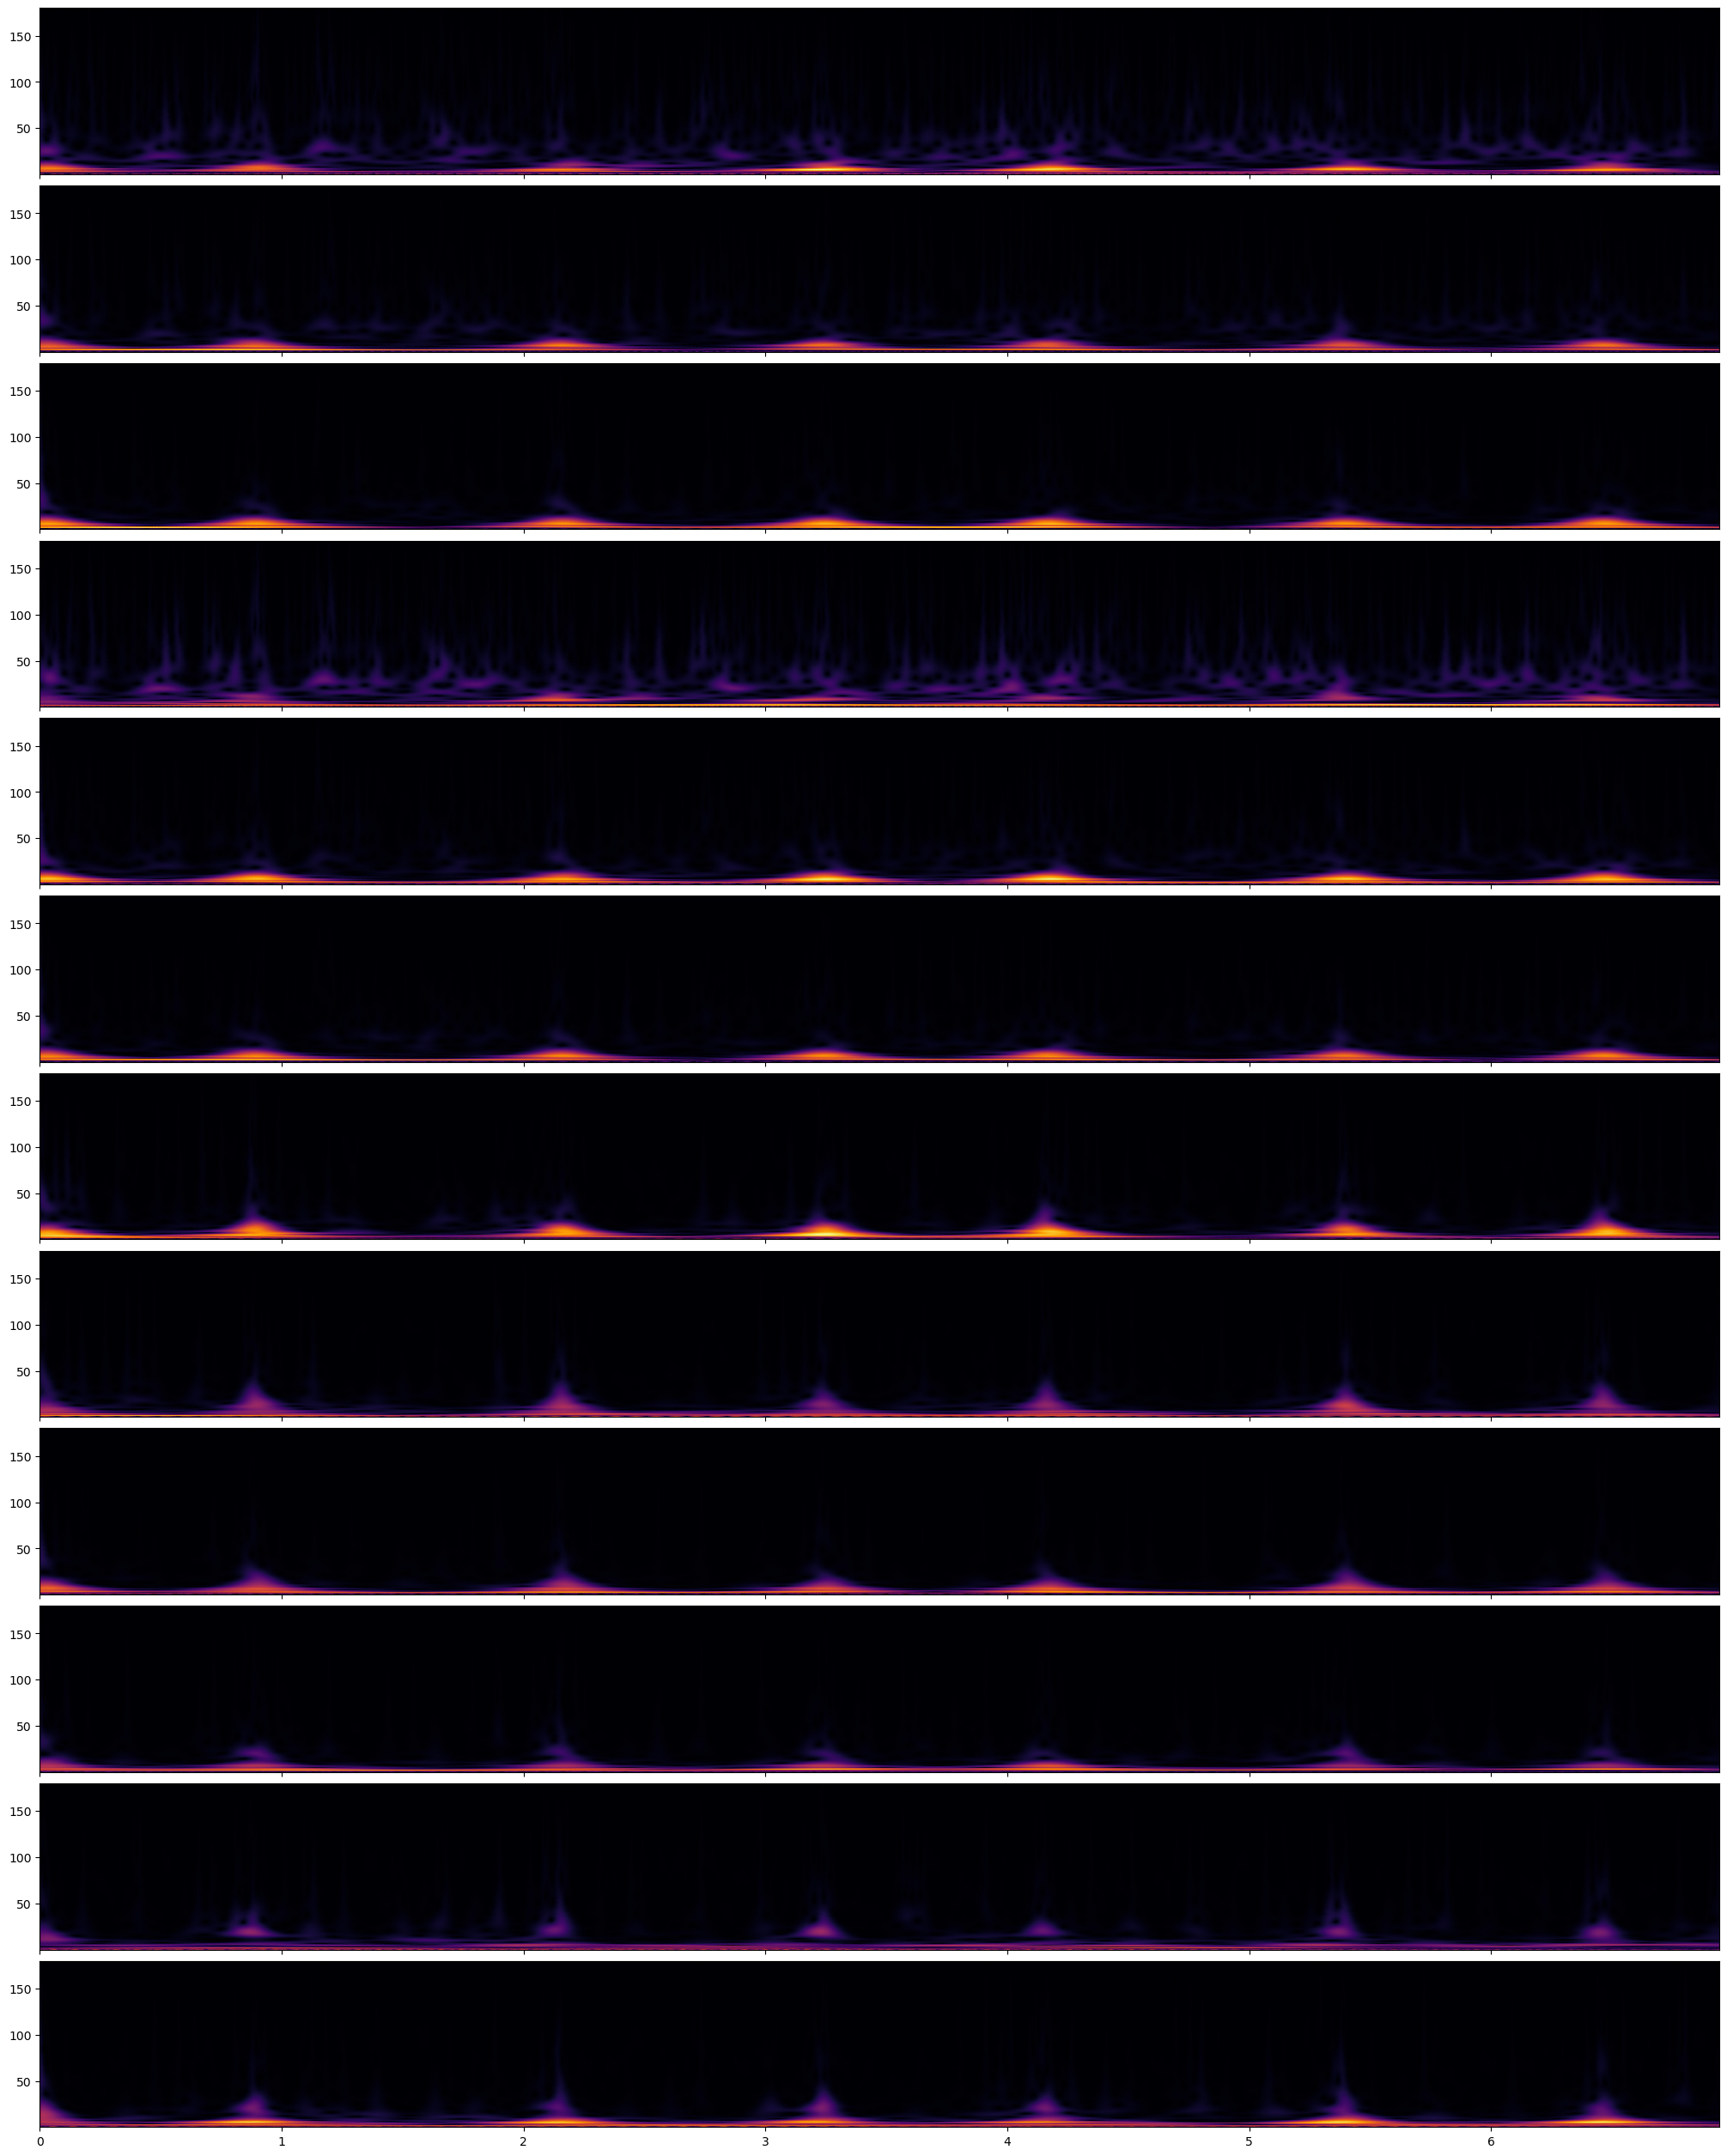

In [57]:
sampling_frequency = 360
fig,ax = plt.subplots(12,1, figsize=(20,25), sharex=True, sharey=False, constrained_layout=True)
for i in range(x_data.shape[2]):
    times, frequencies, coif = cwt_spectrogram(x_data[0,:,i], sampling_frequency, nNotes=24)
    ax[i].pcolormesh(times, frequencies, np.abs(coif), cmap='inferno', shading='gouraud')

In [58]:
coif.shape

(240, 2500)

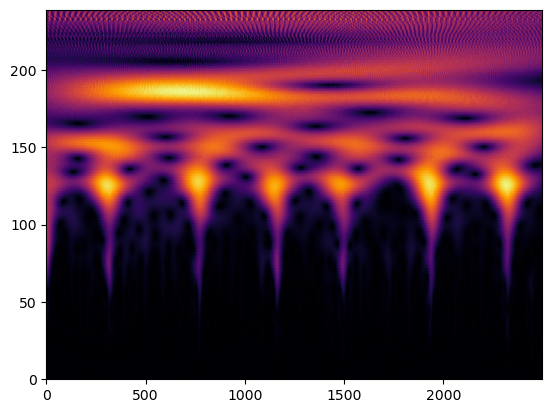

In [66]:
plt.pcolormesh(np.abs(coif), cmap='inferno', shading='gouraud');

In [73]:
def norm(x):
    min_x = x[:,:].min() # Вычисляем минимальное значение x
    max_x = x[:,:].max() - min_x # "Опустим" максимум на min_x

    x[:,:] = (x[:,:]- min_x) / max_x
    x[:,:] = x[:,:] * 0.99 + 0.01
    return x

norm_coif = norm(np.abs(coif))

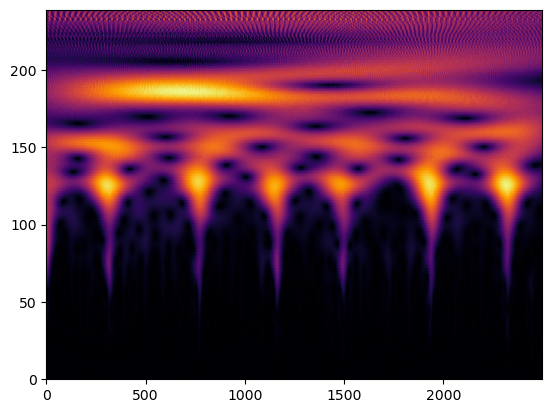

In [74]:
plt.pcolormesh(norm_coif, cmap='inferno', shading='gouraud');

In [128]:
os.mkdir("Спектрограммки 1")
for j in range(x_data.shape[0]):e
    os.mkdir("Спектрограммки 1/Запись " + str(j+1))
    for i in range(x_data.shape[2]):
        times, frequencies, coif = cwt_spectrogram(x_data[j,:,i], sampling_frequency, nNotes=24)
        norm_coif = pd.DataFrame(norm(np.abs(coif)))
        norm_coif.to_csv("Спектрограммки 1/Запись " + str(j+1) + "/Отведение " + str(i+1) + ".csv", index=False, header=False)
pd.DataFrame(data[:,1]).to_csv("Классы 1.csv", index=False, header=False)

In [78]:
x_data.shape

(330, 2500, 12)

In [111]:
pd.DataFrame(data[:,1])

,0
0,1
1,2
2,2
3,2
4,0
...,...
325,0
326,1
327,1
328,1


In [112]:
pd.DataFrame(data[:,1]).to_csv("Классы.csv", index=False, header=False)

In [92]:
pd.DataFrame(norm_coif)

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.073227,0.063137,0.041616,0.023497,0.014332,0.010975,0.010999,0.011410,0.010645,0.011853,...,0.010147,0.010321,0.010502,0.010808,0.012965,0.014204,0.012962,0.010969,0.011006,0.012395
1,0.071740,0.054793,0.033556,0.019165,0.012857,0.010776,0.011452,0.011012,0.011577,0.012101,...,0.010259,0.010511,0.010533,0.011865,0.013989,0.013938,0.012281,0.010597,0.011785,0.012903
2,0.066397,0.046025,0.027056,0.016230,0.012225,0.011342,0.011679,0.011120,0.012287,0.012057,...,0.010491,0.010822,0.011448,0.013232,0.014474,0.013264,0.011520,0.010850,0.012579,0.013077
3,0.074140,0.058862,0.037316,0.021771,0.014121,0.012096,0.011964,0.012247,0.012666,0.012737,...,0.010407,0.010777,0.011187,0.012990,0.014586,0.014699,0.012917,0.010156,0.012259,0.012992
4,0.069124,0.049178,0.030049,0.017694,0.013211,0.012213,0.012538,0.012512,0.013169,0.012993,...,0.010823,0.011257,0.012505,0.014184,0.015172,0.013987,0.011815,0.011390,0.012803,0.013359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.445424,0.487684,0.493987,0.504539,0.452904,0.415292,0.463433,0.353242,0.254164,0.297772,...,0.050489,0.180160,0.342830,0.429550,0.406572,0.422693,0.403400,0.362400,0.305658,0.213999
236,0.443959,0.450955,0.374053,0.224820,0.226161,0.289207,0.318135,0.257720,0.254673,0.366430,...,0.118322,0.121566,0.343932,0.425162,0.353014,0.315272,0.328386,0.369989,0.311783,0.216700
237,0.348019,0.272607,0.272317,0.319941,0.285167,0.174497,0.182011,0.131579,0.098285,0.088869,...,0.339489,0.269312,0.221376,0.258935,0.315386,0.302262,0.287494,0.285546,0.244714,0.177842
238,0.306260,0.342317,0.385589,0.395116,0.411089,0.393759,0.301882,0.231528,0.162558,0.126971,...,0.254047,0.091241,0.127730,0.114845,0.058431,0.102167,0.234817,0.284179,0.281189,0.261838


In [107]:
ceck_coif = pd.read_csv("Запись 1/Отведение 11.csv")

In [120]:
ceck_coif.shape

(240, 2501)

In [119]:
norm_coif.shape

(240, 2500)

In [125]:
ceck_classes = np.asarray(pd.read_csv("Классы.csv"))
ceck_classes.reshape(-1,)

array([2, 2, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 1, 2, 1, 0, 1, 2, 0, 2, 1, 1, 0,
       0, 1, 1, 2, 2, 2, 1, 0, 1, 0, 0, 2, 2, 2, 2, 0, 1, 2, 2, 0, 1, 1,
       2, 2, 0, 0, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 0, 0, 2, 0, 0, 0,
       2, 1, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 1, 0, 2, 1, 1, 1, 0, 1, 2, 0,
       1, 2, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2, 0, 1, 1, 1, 1, 2, 2,
       0, 1, 0, 2, 1, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0, 1, 0, 0, 1, 2, 2, 2,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 1, 1, 0, 0, 2, 2, 0,
       0, 1, 2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 2, 2, 0, 2, 0, 1, 0, 1, 0,
       1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 2, 1, 2,
       2, 1, 2, 0, 1, 1, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2,
       0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 0, 2, 2, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 1, 2, 2, 0, 2, 1, 2, 1, 1, 2, 0, 2, 1, 2,